In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
from scipy import ndimage

In [2]:
def initU(x,y,c):
    U=np.random.rand(x,y,c)
    rsum=U.sum(axis=2)
    NU = np.divide(U,rsum[:,:, None])
    return NU  #(x,y,c)

def initV(c):
    V=np.random.rand(c,1)
    return V #(c,1)

#dim(g) = (15,x,y)

def updateW(g,cen,U,data,q):
    # print(cen.shape)
    mem=(U)**q
    temp1=np.einsum('ca,xyc->xy',cen,mem)#(x,y)
    gt=np.transpose(g,(1,2,0)) #(x,y,15)
    temp2=np.einsum('zxy,xya->zaxy',g,gt) #(15,15,x,y)
    num1=np.einsum('zaxy,xy->za',temp2,temp1)#(15,15)
    num1_inv=np.linalg.inv(num1)
    temp3=np.einsum('zxy,xy->zxy',g,data)#(15,x,y)
    num2=np.einsum('zxy,xy->z',temp3,temp1)#(15,1)
    w=np.einsum('za,z->z',num1_inv,num2) #(15,1)
    return w
def updateB(cen,U,data,q,g):
    w=updateW(g,cen,U,data,q)
    temp=w.T #(1,15)
    b=np.einsum('z,zxy->xy',temp,g)#(x,y)
    # bt=np.transpose(b,(1,2,0)) #(x,y,1)
    return b,w

def updateV(data,b,U,q):
    mem=(U)**q
    temp=np.einsum('xy,xy->xy',data,b)#(x,y)
    num=np.einsum('xy,xyc->xyc',temp,mem)#(x,y,c)
    num=num.sum(axis=1)#(x,c)
    num=num.sum(axis=0)#(1,c)
    denom=np.einsum('xy,xyc->xyc',b**2,mem)#(x,y,c)
    denom=denom.sum(axis=1)#(x,c)
    denom=denom.sum(axis=0)#(1,c)
    cen=num/denom
    return cen.T[:,None] #(c,1)

def updateU(cen,U,data,q,b):
    # b=np.einsum('az,zxy->xy',w.T,g)#(x,y)
    temp=np.einsum('xy,ca->xyc',b,cen)#(x,y,c)
    data_repeat=np.repeat(data[:, :, np.newaxis], repeats=c, axis=2)
    num=(data_repeat-temp)**(2/(1-q))#(x,y,c)
    denom=num.sum(axis=2)#(x,y)
    u=num/denom[:,:,None] #(x,y,c)
    return u

def obj_function(data,b,cen,U,q):
    temp=np.einsum('xy,ca->xyc',b,cen)#(x,y,c)
    data_repeat=np.repeat(data[:, :, np.newaxis], repeats=c, axis=2)
    obj=(data_repeat-temp)**2#(x,y,c)
    mem=(U)**q
    obj=obj*mem
    obj=obj.sum(axis=2)
    obj=obj.sum(axis=1)
    obj=obj.sum()
    return obj

def MICO(data,q,g,c,epochs):
    x,y=data.shape
    Uinit=initU(x,y,c)
    U=Uinit
    Ceninit=initV(c)
    cen=Ceninit
    olddiff=0.0
    obj=[]
    for i in range(epochs):
        b,w=updateB(cen,U,data,q,g)
        # print(b.shape)
        cennew=updateV(data,b,U,q)
        U=updateU(cennew,U,data,q,b)
        objval=obj_function(data,b,cen,U,q)
        obj.append(objval)
        diff=((np.absolute(cen-cennew)).sum(axis=1)).sum()
        print("Itteration ", i, "Differnce", diff)
        if (np.absolute(diff)<0.0001):
          break
        olddiff = diff
        cen = cennew
    return U, cen, obj, b, w

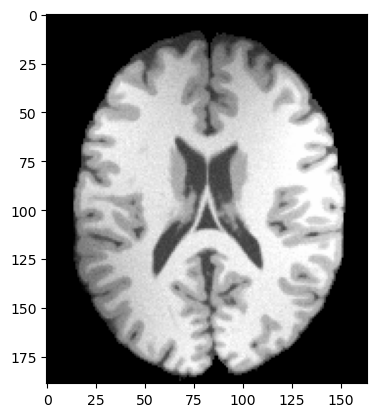

In [29]:
import matplotlib.pyplot as plt 
import matplotlib.image as img 
from PIL import Image
#testimage=img.read('photoshop_created_image5.png')
testimage=img.imread('brainweb90.tif')
testimage2=img.imread('NewImg2_sir.jpg')
# image_path = '\brain mri dataset sir\brainweb67.tif'
# # Open the image
# img = Image.open(image_path)
plt.imshow(testimage,cmap='gray')
plt.show()

In [31]:
print(testimage.shape)

(189, 164, 3)


In [30]:
import cv2
img_gray = cv2.cvtColor(testimage, cv2.COLOR_BGR2GRAY)
cv2.imshow('Grayscale Image', img_gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
print(img_gray.shape)

(189, 164)


In [6]:
print(np.unique(img_gray))

[  0   3   4   5   7   9  10  11  12  13  14  17  19  20  21  23  24  25
  26  27  28  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254]


In [41]:
Height=img_gray.shape[0]
Wide=img_gray.shape[1]

In [42]:
# orthogonal basis generation

x = np.linspace(-1, 1, Wide)  # MATLAB: -1:2/(Wide-1):1
y = np.linspace(-1, 1, Height)  # MATLAB: -1:2/(Height-1):1

# Initialize the bais array
bais = np.zeros((Height, Wide, 15))
X, Y = np.meshgrid(x, y)

# Populate the bais array
bais[:, :, 0] = 1
bais[:, :, 1] = X
bais[:, :, 2] = (3*X**2 - 1) / 2
bais[:, :, 3] = (5*X**3 - 3*X) / 2
bais[:, :, 4] = (35*X**4 - 30*X**2 + 3) / 8
bais[:, :, 5] = Y
bais[:, :, 6] = X * Y
bais[:, :, 7] = (3*X**2 - 1) * Y / 2
bais[:, :, 8] = (5*X**3 - 3*X) * Y / 2
bais[:, :, 9] = (3*Y**2 - 1) / 2
bais[:, :, 10] = (3*Y**2 - 1) * X / 2
bais[:, :, 11] = (3*X**2 - 1) * (3*Y**2 - 1) / 4
bais[:, :, 12] = (5*Y**3 - 3*Y) / 2
bais[:, :, 13] = (5*Y**3 - 3*Y) * X / 2
bais[:, :, 14] = (35*Y**4 - 30*Y**2 + 3) / 8

print(bais)

bais=np.transpose(bais,(2,0,1))
print(bais.shape)

[[[ 1.         -1.          1.         ... -1.          1.
    1.        ]
  [ 1.         -0.98773006  0.96341601 ... -1.          0.98773006
    1.        ]
  [ 1.         -0.97546012  0.92728368 ... -1.          0.97546012
    1.        ]
  ...
  [ 1.          0.97546012  0.92728368 ... -1.         -0.97546012
    1.        ]
  [ 1.          0.98773006  0.96341601 ... -1.         -0.98773006
    1.        ]
  [ 1.          1.          1.         ... -1.         -1.
    1.        ]]

 [[ 1.         -1.          1.         ... -0.937016    0.937016
    0.89614241]
  [ 1.         -0.98773006  0.96341601 ... -0.937016    0.92551887
    0.89614241]
  [ 1.         -0.97546012  0.92728368 ... -0.937016    0.91402175
    0.89614241]
  ...
  [ 1.          0.97546012  0.92728368 ... -0.937016   -0.91402175
    0.89614241]
  [ 1.          0.98773006  0.96341601 ... -0.937016   -0.92551887
    0.89614241]
  [ 1.          1.          1.         ... -0.937016   -0.937016
    0.89614241]]

 [[ 1.  

In [43]:
ROI1 = img_gray.copy()
ROI = np.zeros(ROI1.shape)
# Apply the condition on the copied array: Set values <= 5 to 0
ROI[ROI1 > 5] = 1
ROI[ROI1 <= 5] = 0

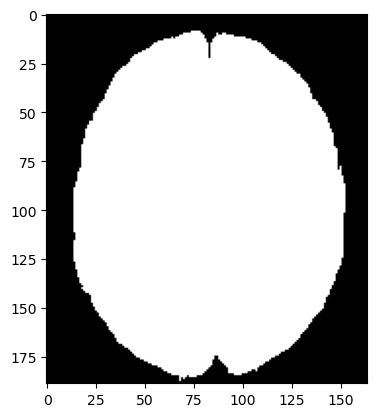

In [44]:
plt.imshow(ROI,cmap='gray')
plt.show()

In [62]:
data=img_gray*ROI
c=3
q=2
g=bais
epochs=1000
U, cen, obj, b, w=MICO(data,q,g,c,epochs)

Itteration  0 Differnce 1.841575816141801
Itteration  1 Differnce 0.16303630602653496
Itteration  2 Differnce 0.2035768780581655
Itteration  3 Differnce 0.5910749333978683
Itteration  4 Differnce 0.7562788398525482
Itteration  5 Differnce 0.4177546457754614
Itteration  6 Differnce 0.4174197049882403
Itteration  7 Differnce 0.27394608716691593
Itteration  8 Differnce 0.2257209669556213
Itteration  9 Differnce 0.191171968951195
Itteration  10 Differnce 0.10850060673109975
Itteration  11 Differnce 0.050193541255187595
Itteration  12 Differnce 0.027062215422454905
Itteration  13 Differnce 0.013196356673818011
Itteration  14 Differnce 0.008273062156647897
Itteration  15 Differnce 0.004868129087813433
Itteration  16 Differnce 0.0032793640310626714
Itteration  17 Differnce 0.0021462027210623555
Itteration  18 Differnce 0.0014698373535325304
Itteration  19 Differnce 0.0009978628206428171
Itteration  20 Differnce 0.0006856527864459658
Itteration  21 Differnce 0.0004700569087036383
Itteration  2

In [63]:
Umax = (U == U.max(axis=2)[:,:,None]).astype(float)
print(Umax.shape)
seg1 = Umax[:,:,0]
# seg1 = np.reshape(seg1,img_gray.shape)
seg2 = Umax[:,:,1]
# seg2 = np.reshape(seg2,img_gray.shape)
seg3 = Umax[:,:,2]
# seg3 = np.reshape(seg3,img_gray.shape)
# seg4 = Umax[:,:,3]
# seg4 = np.reshape(seg4,img_gray.shape)


(189, 164, 3)


In [64]:
seg1,seg2,seg3=sorted([seg1,seg2,seg3],key=lambda m: np.mean(m))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Clusters after FCM')

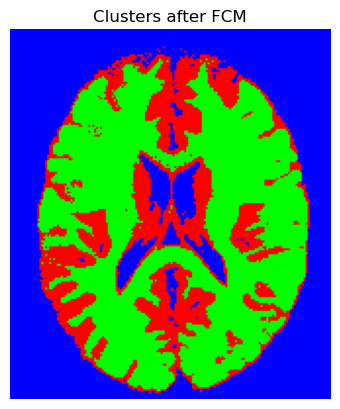

In [65]:
cmb=np.dstack((seg1,seg2*2,seg3*3))
plt.imshow(cmb,cmap='gray')
plt.axis('off')
plt.title('Clusters after FCM')

[]

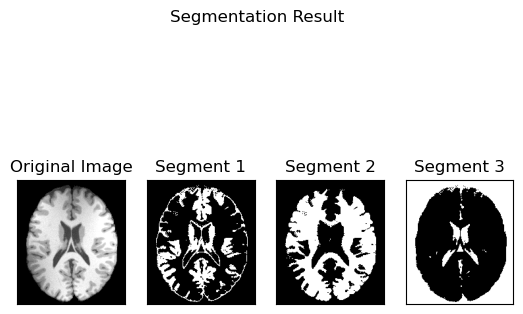

In [66]:
fig, axs = plt.subplots(1,4)
fig.suptitle('Segmentation Result')
axs[0].imshow(data,'gray')
axs[0].set_title('Original Image')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(seg1,'gray')
axs[1].set_title('Segment 1')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].imshow(seg2,'gray')
axs[2].set_title('Segment 2')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[3].imshow(seg3,'gray')
axs[3].set_title('Segment 3')
axs[3].set_xticks([])
axs[3].set_yticks([])
# axs[4].imshow(seg4,'gray')
# axs[4].set_title('Segment 4')
# axs[4].set_xticks([])
# axs[4].set_yticks([])

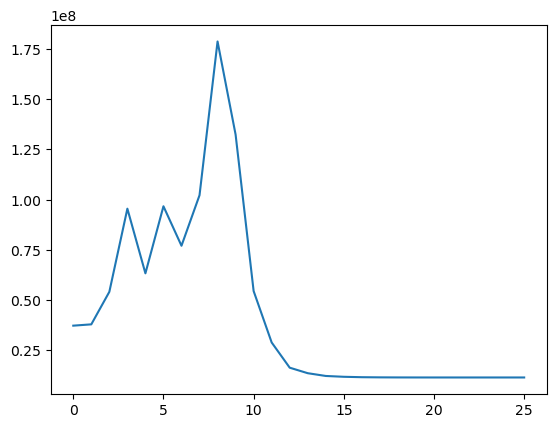

In [67]:
def Plot(obj):
  y = obj
  y.pop(0)
  x = list(range(0,len(obj)))
  return plt.plot(x, y)
Plot(obj)

In [68]:
print(w.shape)

(15,)


In [69]:
print(w)

[ 2637.16335109   222.61280344 -1550.5249883    -48.57794594
  -267.02273398   300.96877224   133.54351805  -232.76309125
   -67.16140712 -1272.86243115  -148.12839266   173.79457708
    53.3121499    -84.90370694  -135.60972   ]


In [70]:
print(np.unique(bais))

[-1.        -0.9893617 -0.9893617 ...  0.9893617  0.9893617  1.       ]


In [71]:
print(b.shape)

(189, 164)


In [72]:
print(np.unique(b))

[-581.00783699 -528.01125118 -505.62501081 ... 3987.05056796 3987.18180899
 3987.2011941 ]


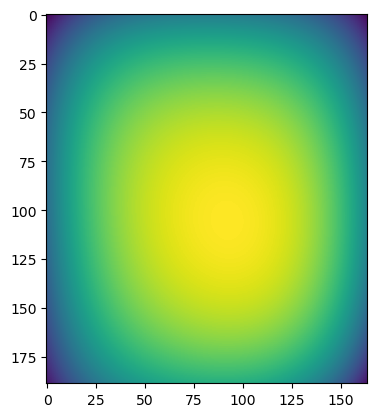

In [73]:
plt.imshow(b)
plt.show()

In [74]:
print(np.unique(data/b))

[-0.          0.00334585  0.00421433 ...  0.09654903  0.09686578
  0.09692041]


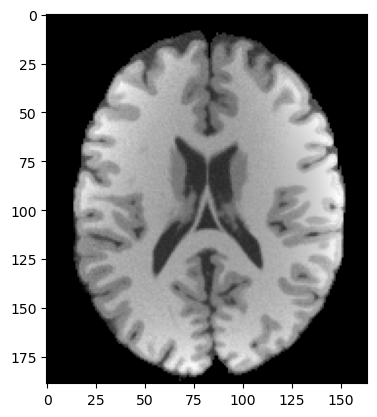

In [75]:
plt.imshow((data/(b)),cmap='gray')
plt.show()

In [76]:
ROI1 = img_gray.copy()
ROI = np.zeros(ROI1.shape)
# Apply the condition on the copied array: Set values <= 5 to 0
ROI[ROI1 > 5] = 1
ROI[ROI1 <= 5] = 0

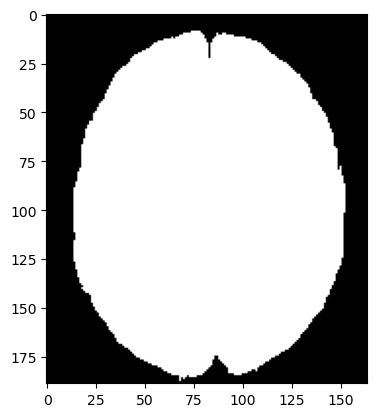

In [77]:
plt.imshow(ROI,cmap='gray')
plt.show()

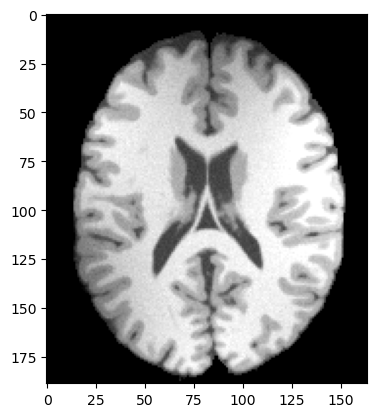

In [78]:
plt.imshow((img_gray)*ROI,cmap='gray')
plt.show()